In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('model_dataset.xlsx')
df = df.dropna()

In [3]:
X = df[['shell_color', 'time_description', 'iso_press_avg', 'Avg Temp', 'Avg Humidity','booth']]
y = df['blister']

In [4]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['iso_press_avg', 'Avg Temp', 'Avg Humidity']

features_log_minmax_transform = pd.DataFrame(data = X)
features_log_minmax_transform[numerical] = scaler.fit_transform(X[numerical])

In [5]:
# making booth a categorical variable by changing from int to string
X['booth'] = X['booth'].astype(str)

C:\Users\tpeterson\AppData\Local\Temp\ipykernel_15712\4213308690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['booth'] = X['booth'].astype(str)


In [6]:
X = pd.get_dummies(X)

## TRAINING 
## SMOTE (Synthetic Minority Oversampling Technique) using Standard Random Forest

Because this dataset is highly imbalanced (less than 1% of spas have been reported w/ blistering), we need to use SMOTE to make it balanced. The dataset will be trained and fit with real and synthetic blister data and will then be used to predict real values from the testing dataset. 

Mean f1: 0.978
Mean recall: 0.986
Mean precision: 0.971


C:\Users\tpeterson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


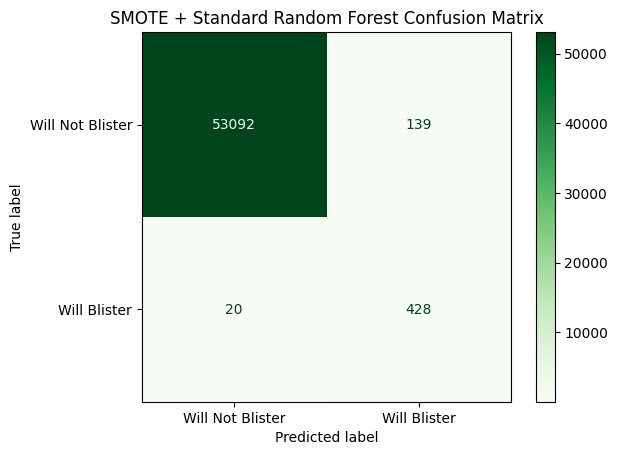

In [7]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)

#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')

#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly split dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, stratify=y)

#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)

#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

#probabilities result
y_pred_proba = SMOTE_SRF.predict_proba(X_test)

#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Will Not Blister', 'Will Blister'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

## TESTING
## LIVE DATA

In [12]:
y_pred_proba_live = SMOTE_SRF.predict_proba(X)
y_pred_live = SMOTE_SRF.predict(X)

In [13]:
y_pred_proba_live
lst2 = [item[1] for item in y_pred_proba_live]

In [14]:
len(lst2)

54221

In [15]:
df['prediction'] = y_pred_live
df['probability'] = lst2

In [17]:
df.to_excel('results.xlsx', index = False)